In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

In [2]:
df = pd.read_csv('/kaggle/input/melbourne-housing-snapshot/melb_data.csv')
print(df.shape[0])
df.head(3)


13580


,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra,-37.7996,144.9984,Northern Metropolitan,4019.0
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra,-37.8079,144.9934,Northern Metropolitan,4019.0
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.0,1900.0,Yarra,-37.8093,144.9944,Northern Metropolitan,4019.0


In [3]:
df.groupby(['Regionname']).count()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Propertycount
Regionname,,,,,,,,,,,,,,,,,,,,
Eastern Metropolitan,1471,1471,1471,1471,1471,1471,1471,1471,1471,1471,1471,1471,1468,1471,709,828,1229,1471,1471,1471
Eastern Victoria,53,53,53,53,53,53,53,53,53,53,53,53,53,53,30,31,44,53,53,53
Northern Metropolitan,3890,3890,3890,3890,3890,3890,3890,3890,3890,3890,3890,3890,3869,3890,2097,2380,3554,3890,3890,3890
Northern Victoria,41,41,41,41,41,41,41,41,41,41,41,41,40,41,28,27,26,41,41,41
South-Eastern Metropolitan,450,450,450,450,450,450,450,450,450,450,450,450,450,450,220,242,325,450,450,450
Southern Metropolitan,4695,4695,4695,4695,4695,4695,4695,4695,4695,4695,4695,4695,4668,4695,2418,2902,4340,4695,4695,4695
Western Metropolitan,2948,2948,2948,2948,2948,2948,2948,2948,2948,2948,2948,2948,2938,2948,1607,1772,2668,2948,2948,2948
Western Victoria,32,32,32,32,32,32,32,32,32,32,32,32,32,32,21,23,25,32,32,32


In [4]:
df.isnull().sum()

Suburb              0
Address             0
Rooms               0
Type                0
Price               0
Method              0
SellerG             0
Date                0
Distance            0
Postcode            0
Bedroom2            0
Bathroom            0
Car                62
Landsize            0
BuildingArea     6450
YearBuilt        5375
CouncilArea      1369
Lattitude           0
Longtitude          0
Regionname          0
Propertycount       0
dtype: int64

In [5]:
df['Bedroom2'].max()

20.0

In [6]:
df['Car'].max()

10.0

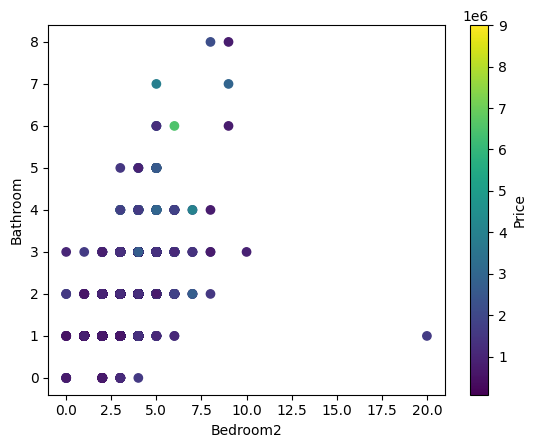

In [7]:
plt.scatter(df['Bedroom2'], df['Bathroom'], c=df['Price'], cmap='viridis')
plt.colorbar(label='Price')
plt.xlabel('Bedroom2')
plt.ylabel('Bathroom')
plt.show()

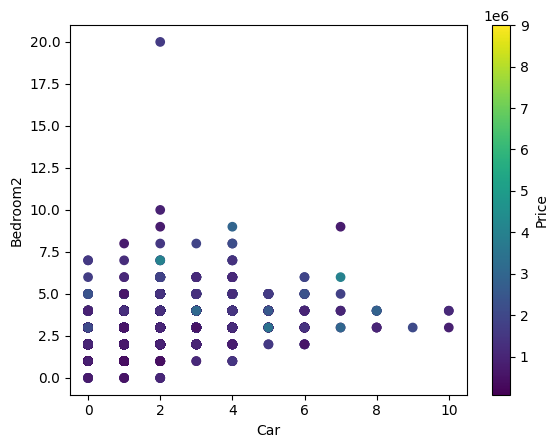

In [8]:
plt.scatter(df['Car'], df['Bedroom2'], c=df['Price'], cmap='viridis')
plt.colorbar(label='Price')
plt.xlabel('Car')
plt.ylabel('Bedroom2')
plt.show()

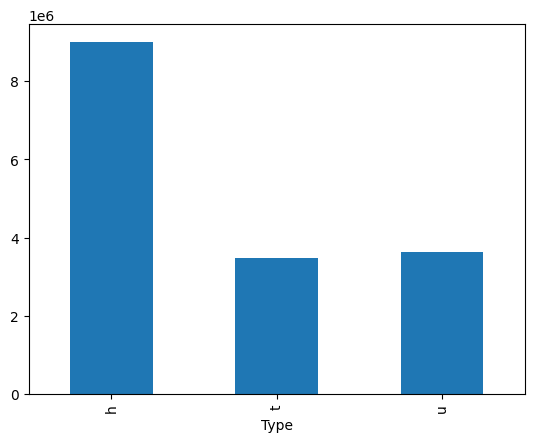

In [9]:
df.groupby('Type')['Price'].max().plot(kind='bar')
plt.show()

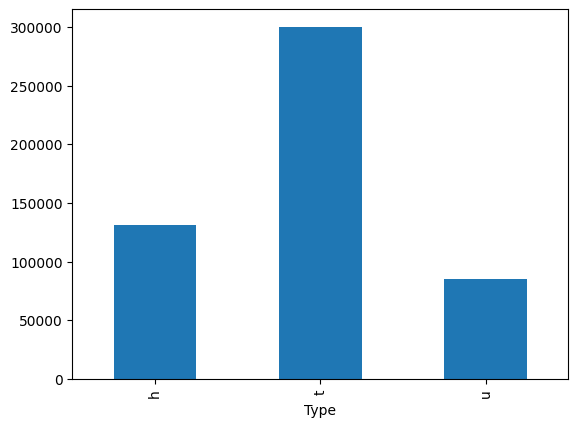

In [10]:
df.groupby('Type')['Price'].min().plot(kind='bar')
plt.show()

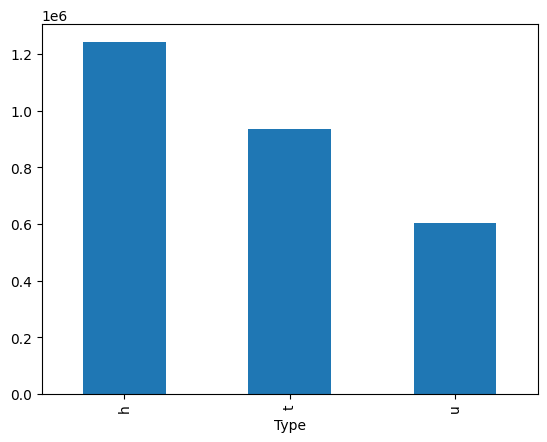

In [11]:
df.groupby('Type')['Price'].mean().plot(kind='bar')
plt.show()

In [12]:
# ['Rooms', 'Type', 'Distance', 'Bedroom2', 'Bathroom', 'Car', 'Landsize', 'Regionname', 'Propertycount']
features = ['Rooms', 'Type', 'Distance', 'Bedroom2', 'Car', 'Bathroom', 'Landsize']
target = 'Price'

df = df[features + [target]]
df = df.dropna()
print(df.shape[0])

le = LabelEncoder()
df.loc[:, 'Type'] = le.fit_transform(df['Type'])
# df.loc[:, 'Regionname'] = le.fit_transform(df['Regionname'])

for column in df.columns:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    df = df.loc[(df[column] >= (Q1 - 1.5*IQR)) & (df[column] <= (Q3 + 1.5*IQR)), :]
print(df.shape[0])

df_features = df[features].copy()
df_target = df[target].copy()

13518
11143


In [13]:
def find_outliers_IQR(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    outliers = data[(data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))]
    return outliers

for column in df_features.columns:
    outliers = find_outliers_IQR(df_features[column])
    print(f'{column}: {outliers.shape[0]}')

outliers = find_outliers_IQR(df_target)
print(f'Price: {outliers.shape[0]}')

Rooms: 0
Type: 0
Distance: 62
Bedroom2: 0
Car: 0
Bathroom: 0
Landsize: 10
Price: 94


In [14]:
X_train, X_test, y_train, y_test = train_test_split(df_features, df_target, test_size=0.3, random_state=22004)

# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# min_max_scaler = MinMaxScaler()
# X_train = min_max_scaler.fit_transform(X_train)
# X_test = min_max_scaler.transform(X_test)

# model = LinearRegression()
# model.fit(X_train, y_train)

model = DecisionTreeRegressor(random_state=0)
model.fit(X_train, y_train)
predictions = model.predict(X_test)

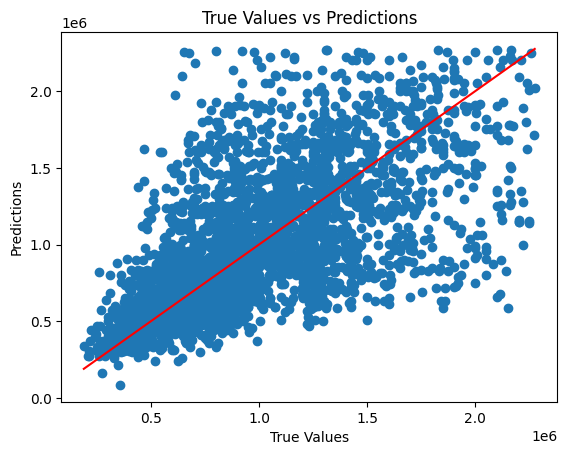

In [15]:
plt.scatter(y_test, predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True Values vs Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red')

plt.show()